(100000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     100000 non-null  object
 1   type    100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB
Saved to phishing_features.csv
Training Accuracy:  1.0

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     15094
           1       0.99      0.97      0.98     14906

    accuracy                           0.98     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.98      0.98      0.98     30000

Accuracy: 98.00333333333333 %


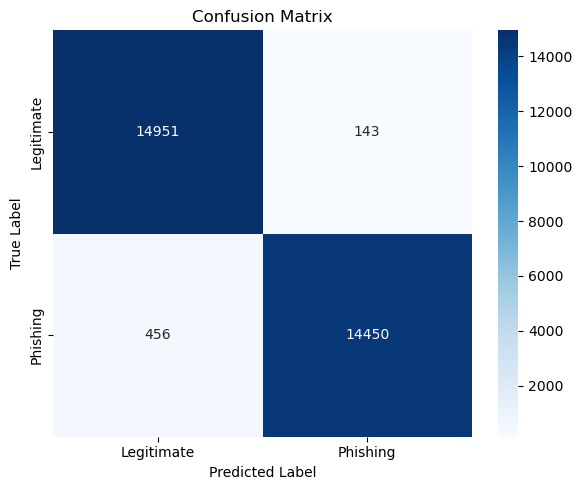

has_typosquatting_pattern: 0.0255
has_unusual_subdomain: 0.0570
url_length: 0.0191
num_dots: 0.0294
num_hyphens: 0.0076
num_digits: 0.0094
url_entropy: 0.0453
num_tokens: 0.0188
special_char_count: 0.0304
special_char_ratio: 0.0802
has_legit_tld: 0.1060
domain_entropy: 0.0787
domain_length: 0.0328
has_suspicious_tld: 0.0089
is_free_hosting: 0.0213
num_subdomains: 0.0513
token_count_domain: 0.0495
delimiters_in_domain: 0.0216
brand_max_partial_ratio: 0.0207
brand_max_token_set_ratio: 0.0206
path_entropy: 0.0502
num_path_segments: 0.0137
num_delimiters_path: 0.0264
longest_token_len_path: 0.0200
path_length: 0.0316
ratio_url_path: 0.0262
normalized_brand_similarity: 0.0293
digit_ratio_domain: 0.0325
char_repetition_ratio: 0.0322
has_random_folder: 0.0038


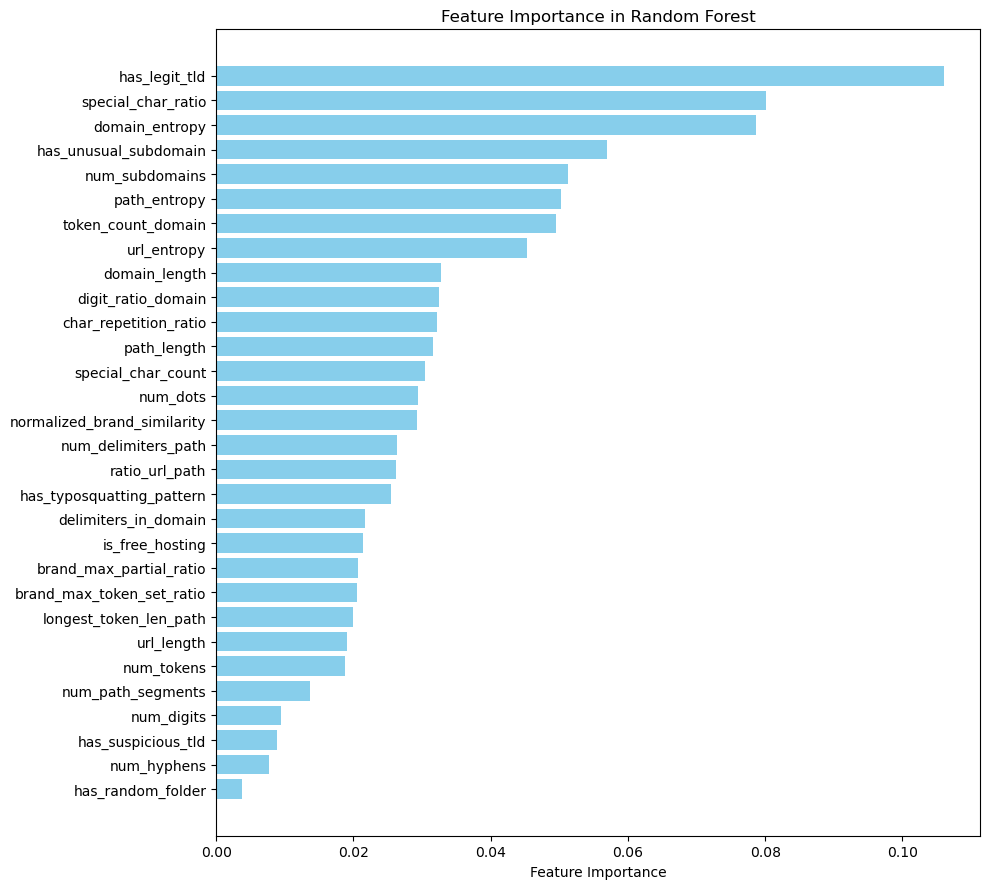

False Positives:
                                                                                                                                                         url
79022                                                                                                                         https://www.online.loyno.edu/
39590                                                                                                                 https://www.multiculturalcanada.ca/zw
26970                                                                                                                         https://harishsen.tripod.com/
33054                                                                                                              https://www.centreeatondemontreal.com/en
17961                                                                                                                             https://www.kamp-mali.hr/
38621                                         

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.output_scroll { overflow-x: visible !important; }</style>"))


# Import necessary libraries for data handling and machine learning
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the dataset from CSV file
df = pd.read_csv('final_dataset.csv')

# Check the shape of the dataset (rows, columns)
print(df.shape)

df_phish = df[df.type=='phishing']
df_legitimate = df[df.type=='legitimate']

# Get info about data types, memory usage, and non-null counts
df.info()

# -------------------------------------------------------------
# LABEL ENCODING

# Convert the 'type' column to numerical binary labels: 0 for legitimate, 1 for phishing
df['label'] = df['type'].map({'legitimate': 0, 'phishing': 1})

# -------------------------------------------------------------

# ================================
# FEATURE ENGINEERING
# ================================

import re
import numpy as np
from scipy.stats import entropy
from collections import Counter
from urllib.parse import urlparse, parse_qs
import tldextract
from fuzzywuzzy import fuzz
import pandas as pd  # Ensure pandas is imported

# -------------------------------
# Helper Functions
# -------------------------------

def shannon_entropy(s: str) -> float:
    if not s:
        return 0
    prob = [float(s.count(c)) / len(s) for c in dict.fromkeys(list(s))]
    return -sum(p * np.log2(p) for p in prob)

def count_delimiters_in_string(s: str) -> int:
    delimiters = list(".;()[]{}+,-_~`!@#$%^&*|\\\"':<>?/")
    return sum(s.count(d) for d in delimiters)

# -------------------------------
# Constants
# -------------------------------

top_level_domains = [
    'com', 'org', 'net', 'info', 'biz', 'edu', 'gov', 'co', 'uk', 'ru', 'br',
    'de', 'cn', 'in', 'jp', 'fr', 'au', 'us', 'it', 'nl', 'es', 'ca', 'ch',
]

suspicious_tlds = [
    'xyz', 'top', 'club', 'info', 'site', 'online', 'win', 'loan', 'click',
    'pw', 'icu', 'cn', 'ru', 'cc', 'biz'
]

free_hosts = [
    'weebly', 'webcindario', 'w3spaces', 'wixsite', '000webhost', 'github.io', 'workers.dev'
]

known_brands = [
    'rakuten', 'paypal', 'google', 'amazon', 'facebook', 'apple',
    'microsoft', 'netflix', 'instagram', 'youtube', 'linkedin',
    'twitter', 'wellsfargo', 'chase', 'bankofamerica', 'paypal',
    'gmail', 'icloud', 'spotify', 'ebay', 'dropbox',
    'americanexpress', 'visa', 'mastercard', 'reddit',
    'microsoftoffice', 'zoom', 'github', 'adobe', 'airbnb',
    'uber', 'whatsapp', 'discord',
]

# ================================
# FULL URL-BASED FEATURES
# ================================

def count_dots_in_url(url):
    return url.count('.')

def url_entropy(url: str) -> float:
    if not url:
        return 0
    prob = [float(url.count(c)) / len(url) for c in set(url)]
    return -sum(p * np.log2(p) for p in prob)

def count_tokens(url: str) -> int:
    tokens = re.split(r'[/:.?=&_\-]+', url)
    tokens = [t for t in tokens if t]
    return len(tokens)

def count_legit_tlds(url: str, tld_list: list) -> int:
    count = 0
    for tld in tld_list:
        if re.search(r'\.' + re.escape(tld) + r'\b', url):
            count += 1
    return count

def has_suspicious_tld(url: str) -> int:
    for tld in suspicious_tlds:
        if re.search(r'\.' + re.escape(tld) + r'\b', url):
            return 1
    return 0



special_chars_pattern = r"[!@#\$%\^&\*\(\)_\+\-=\[\]\{\};:'\",<>\./\?\\|`~]"

df['url_length'] = df['url'].str.len()
df['num_dots'] = df['url'].str.count(r'\.')
df['num_hyphens'] = df['url'].str.count('-')
df['num_digits'] = df['url'].str.count(r'\d')
df['url_entropy'] = df['url'].apply(url_entropy)
df['num_tokens'] = df['url'].apply(count_tokens)
df['special_char_count'] = df['url'].apply(lambda x: len(re.findall(special_chars_pattern, x)))
df['special_char_ratio'] = df['special_char_count'] / (df['url'].str.len() + 1e-6)
df['dots_in_url'] = df['url'].apply(count_dots_in_url)




# ================================
# DOMAIN-BASED FEATURES
# ================================


from urllib.parse import urlparse

DELIMITERS = set(".;,()_+-=&%$!*")

def count_delimiters_in_domain(url):
    try:
        domain = urlparse(url).netloc
        return sum(1 for c in domain if c in DELIMITERS)
    except:
        return 0
        
def count_tokens_in_domain(url):
    try:
        domain = urlparse(url).netloc
        tokens = domain.split('.')
        return len([t for t in tokens if t])
    except:
        return 0

def count_legit_tlds(url: str, tld_list: list) -> int:
    parsed_url = urlparse(url)
    domain = parsed_url.netloc.lower()  # just the domain, e.g. "www.example.com"
    count = 0
    for tld in tld_list:
        # Check if domain ends with the TLD or has TLD preceded by a dot
        # Use regex to avoid partial matches (e.g., '.com' not matching '.company')
        if re.search(r'\.' + re.escape(tld) + r'$', domain) or domain == tld:
            count += 1
    return count


def has_legit_tld(url: str, tld_list: list) -> int:
    domain = urlparse(url).netloc.lower()
    for tld in tld_list:
        if domain == tld or domain.endswith('.' + tld):
            return 1
    return 0

def has_suspicious_tld(url: str) -> int:
    for tld in suspicious_tlds:
        if re.search(r'\.' + re.escape(tld) + r'\b', url):
            return 1
    return 0

from urllib.parse import urlparse
from collections import Counter
from scipy.stats import entropy

def domain_entropy(url: str) -> float:
    try:
        parsed_url = urlparse(url)
        domain = parsed_url.netloc.lower()
        if domain.startswith("www."):
            domain = domain[4:]
        char_counts = Counter(domain)
        total_chars = sum(char_counts.values())
        probs = [count / total_chars for count in char_counts.values()]
        return entropy(probs, base=2)
    except Exception:
        return 0.0



def domain_length(url: str) -> int:
    try:
        domain = tldextract.extract(url).domain
        return len(domain)
    except:
        return 0

def brand_similarity_scores(url):
    ext = tldextract.extract(url)
    domain = ext.domain.lower()
    
    fuzz_ratios = []
    fuzz_partial_ratios = []
    fuzz_token_set_ratios = []
    len_diffs = []
    
    for brand in known_brands:
        brand_lower = brand.lower()
        fuzz_ratios.append(fuzz.ratio(domain, brand_lower))
        fuzz_partial_ratios.append(fuzz.partial_ratio(domain, brand_lower))
        fuzz_token_set_ratios.append(fuzz.token_set_ratio(domain, brand_lower))
        len_diffs.append(abs(len(domain) - len(brand_lower)))
    
    return {
        'brand_max_ratio': max(fuzz_ratios),
        'brand_max_partial_ratio': max(fuzz_partial_ratios),
        'brand_max_token_set_ratio': max(fuzz_token_set_ratios),
        'brand_len_diff_min': min(len_diffs)
    }

df['has_legit_tld'] = df['url'].apply(lambda x: has_legit_tld(x, top_level_domains))
df['domain_entropy'] = df['url'].apply(domain_entropy)
df['domain_length'] = df['url'].apply(domain_length)
#df['num_legit_tlds'] = df['url'].apply(lambda x: count_legit_tlds(x, top_level_domains))
df['has_suspicious_tld'] = df['url'].apply(has_suspicious_tld)
df['is_free_hosting'] = df['url'].str.contains('|'.join(free_hosts), case=False).astype(int)
df['num_subdomains'] = df['url'].str.extract(r'://([^/]+)')[0].str.count(r'\.') - 1
df['token_count_domain'] = df['url'].apply(count_tokens_in_domain)
df['delimiters_in_domain'] = df['url'].apply(count_delimiters_in_domain)

# Apply brand similarity features
brand_sim_df = df['url'].apply(brand_similarity_scores).apply(pd.Series)
df = pd.concat([df, brand_sim_df], axis=1)

similarity_threshold = 80
df['brand_similar_flag'] = (
    (df['brand_max_ratio'] >= similarity_threshold) |
    (df['brand_max_partial_ratio'] >= similarity_threshold) |
    (df['brand_max_token_set_ratio'] >= similarity_threshold)
).astype(int)

# ================================
# PATH-BASED FEATURES
# ================================

import tldextract
from urllib.parse import urlparse, parse_qs

import re
from urllib.parse import urlparse, parse_qs

def count_digits_in_query(url):
    try:
        parsed = urlparse(url)
        queries = parse_qs(parsed.query)
        digit_count = sum(sum(c.isdigit() for c in v) for val in queries.values() for v in val)
        return digit_count
    except:
        return 0

def ratio_url_path(url):
    """F12: Ratio of length of full URL to path length."""
    parsed = urlparse(url)
    path_len = len(parsed.path)
    if path_len == 0:
        return len(url)
    return len(url) / path_len

def path_entropy(url: str) -> float:
    try:
        path = urlparse(url).path
        return shannon_entropy(path)
    except:
        return 0

def num_path_segments(url: str) -> int:
    try:
        path = urlparse(url).path
        segments = [seg for seg in path.split('/') if seg]
        return len(segments)
    except:
        return 0

def num_delimiters_path(url: str) -> int:
    try:
        path = urlparse(url).path
        return count_delimiters_in_string(path)
    except:
        return 0

def longest_token_len_path(url: str) -> int:
    try:
        path = urlparse(url).path
        tokens = re.split(r'[/.\\-_]+', path)
        tokens = [t for t in tokens if t]
        if not tokens:
            return 0
        return max(len(t) for t in tokens)
    except:
        return 0

df['path_entropy'] = df['url'].apply(path_entropy)
df['num_path_segments'] = df['url'].apply(num_path_segments)
df['num_delimiters_path'] = df['url'].apply(num_delimiters_path)
df['longest_token_len_path'] = df['url'].apply(longest_token_len_path)
df['path_length'] = df['url'].apply(lambda x: urlparse(x).path).str.len()
df['ratio_url_path'] = df['url'].apply(ratio_url_path)
df['digits_in_query'] = df['url'].apply(count_digits_in_query)

import pandas as pd
import re
from urllib.parse import urlparse, parse_qs
import tldextract
from fuzzywuzzy import fuzz

# Load dataset (assuming it's already loaded in your pipeline as df)
# df = pd.read_csv('brand_new_dataset.csv')

# -------------------------------
# Constants for New Features
# -------------------------------

free_hosts = [
    'weebly', 'webcindario', 'w3spaces', 'wixsite', '000webhost', 'github.io',
    'workers.dev', 'webflow.io', 'square.site', 'webwave.dev', 'nftstorage.link'
]

known_brands = [
    'rakuten', 'paypal', 'google', 'amazon', 'facebook', 'apple',
    'microsoft', 'netflix', 'instagram', 'youtube', 'linkedin',
    'twitter', 'wellsfargo', 'chase', 'bankofamerica', 'paypal',
    'gmail', 'icloud', 'spotify', 'ebay', 'dropbox',
    'americanexpress', 'visa', 'mastercard', 'reddit',
    'microsoftoffice', 'zoom', 'github', 'adobe', 'airbnb',
    'uber', 'whatsapp', 'discord',
]

# -------------------------------
# New Feature Functions
# -------------------------------

def has_ip_address(url: str) -> int:
    try:
        parsed = urlparse(url)
        domain = parsed.netloc
        # Check for IPv4 (e.g., 192.168.1.1) or IPv6
        ip_pattern = r'^(?:(?:[0-9]{1,3}\.){3}[0-9]{1,3}|(?:[0-9a-fA-F]{1,4}:){7}[0-9a-fA-F]{1,4})$'
        return 1 if re.match(ip_pattern, domain) else 0
    except:
        return 0

def has_url_shortener(url: str) -> int:
    shorteners = ['tinyurl.com', 'bit.ly', 't.co', 'is.gd', 'goo.by', 'appurl.io']
    parsed = urlparse(url)
    domain = parsed.netloc.lower()
    return 1 if any(shortener in domain for shortener in shorteners) else 0

def has_suspicious_keywords(url: str) -> int:
    suspicious_keywords = ['login', 'update', 'account', 'secure', 'verify', 'signin', 'password']
    parsed = urlparse(url)
    path_query = parsed.path.lower() + parsed.query.lower()
    return 1 if any(keyword in path_query for keyword in suspicious_keywords) else 0

def count_query_params(url: str) -> int:
    try:
        parsed = urlparse(url)
        queries = parse_qs(parsed.query)
        return len(queries)
    except:
        return 0

def normalized_brand_similarity(url: str) -> float:
    ext = tldextract.extract(url)
    domain = ext.domain.lower()
    if not domain:
        return 0.0
    max_score = 0
    for brand in known_brands:
        brand_lower = brand.lower()
        ratio = fuzz.ratio(domain, brand_lower)
        partial_ratio = fuzz.partial_ratio(domain, brand_lower)
        token_set_ratio = fuzz.token_set_ratio(domain, brand_lower)
        # Weighted average, adjusted by length difference
        len_diff = abs(len(domain) - len(brand_lower))
        weight = 1 / (1 + len_diff)  # Penalize large length differences
        score = (0.4 * ratio + 0.3 * partial_ratio + 0.3 * token_set_ratio) * weight
        max_score = max(max_score, score)
    return max_score

# -------------------------------
# Apply New Features
# -------------------------------

df['has_ip_address'] = df['url'].apply(has_ip_address)
df['has_url_shortener'] = df['url'].apply(has_url_shortener)
df['has_suspicious_keywords'] = df['url'].apply(has_suspicious_keywords)
df['num_query_params'] = df['url'].apply(count_query_params)
df['is_free_hosting'] = df['url'].str.contains('|'.join(free_hosts), case=False, na=False).astype(int)
df['normalized_brand_similarity'] = df['url'].apply(normalized_brand_similarity)

##from [14]
# Define suspicious keywords (you can expand this list)
suspicious_keywords = ['login', 'verify', 'update', 'secure', 'account', 'banking']

df['num_slashes'] = df['url'].apply(lambda x: x.count('/'))
df['num_hyphens'] = df['url'].apply(lambda x: x.count('-'))
df['num_question_marks'] = df['url'].apply(lambda x: x.count('?'))
df['presence_of_query'] = df['url'].apply(lambda x: 1 if '?' in x else 0)
df['number_of_suspicious_keywords'] = df['url'].apply(
        lambda x: sum(1 for word in suspicious_keywords if word in x.lower()))

import re
from urllib.parse import urlparse, parse_qs, unquote

def count_empty_query_params(url):
    query = urlparse(url).query
    params = parse_qs(query)
    return sum(1 for v in params.values() if all(not item for item in v))

def count_percent(url):
    return url.count('%')

def count_repeated_sequences_domain(domain):
    # Count sequences repeated at least twice (e.g. "aaa" or "abcabc")
    matches = re.findall(r'([a-z0-9]{2,})\1+', domain)
    return len(matches)

def digit_ratio_domain(domain):
    digits = sum(c.isdigit() for c in domain)
    return digits / len(domain) if len(domain) > 0 else 0

def email_exist(url):
    # Check if an email-like pattern exists in URL
    return 1 if re.search(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b', url) else 0

def has_at_symbol(url):
    return 1 if '@' in url else 0

def has_hex_encoding(url):
    # Check for hex encoding like %20, %3D etc.
    return 1 if re.search(r'%[0-9a-fA-F]{2}', url) else 0

def has_hex_ip(url):
    # Look for hex IP like %5B...%5D or hex inside brackets or IP in hex format
    return 1 if re.search(r'%5B|%5D|0x[0-9a-fA-F]{2,}', url) else 0

def has_https(url):
    return 1 if url.startswith('https://') else 0

def has_nested_url(url):
    # Check if there's a URL inside the URL (http(s):// appears after the first one)
    parts = url.split('://')
    return 1 if len(parts) > 2 else 0

def has_redirect_param(url):
    # Common redirect param names in phishing URLs
    redirect_params = ['redirect', 'redir', 'url', 'next', 'destination', 'dest', 'path', 'callback']
    query = urlparse(url).query.lower()
    return 1 if any(p in query for p in redirect_params) else 0

def has_random_folder(path):
    # Detect folders with suspicious randomness: sequences of >=5 chars with mix of digits and letters
    folders = path.split('/')
    for folder in folders:
        if len(folder) >= 5 and re.search(r'[a-zA-Z]', folder) and re.search(r'\d', folder):
            return 1
    return 0

def has_suspicious_extension(path):
    # Suspicious file extensions common in malware/phishing
    suspicious_exts = ['.exe', '.scr', '.bat', '.cmd', '.js', '.jse', '.vbs', '.vbe', '.wsf', '.wsh', '.ps1', '.ps2', '.msc']
    return 1 if any(path.lower().endswith(ext) for ext in suspicious_exts) else 0

def has_unusual_delims(url):
    # Check for uncommon delimiters in URL (other than usual - _ . / : ? & =)
    unusual = re.findall(r'[^a-zA-Z0-9\-_\./:?&=%@]', url)
    return 1 if len(unusual) > 0 else 0

def num_digits_in_query(query):
    return sum(c.isdigit() for c in query)

def num_dirs(path):
    # Count of directories (ignore empty segments)
    return len([p for p in path.split('/') if p])

def num_parameters(query):
    # Number of query parameters
    return len(parse_qs(query))

def num_tokens_domain(domain):
    # Split domain by '.' and count tokens (e.g. www.google.com = 3)
    return len(domain.split('.'))

def slash_path_count(path):
    # Number of slashes in path (should be similar to num_dirs but counts slashes explicitly)
    return path.count('/')

def url_ends_with_numbers(path):
    # Does the path end with digits? Return 1 if yes else 0
    return 1 if re.search(r'\d+$', path) else 0

from urllib.parse import urlparse

# Parse the URLs once here
parsed = df['url'].apply(urlparse)

df['count_empty_query_params'] = df['url'].apply(count_empty_query_params)
df['count_percent'] = df['url'].apply(count_percent)
df['count_repeated_sequences_domain'] = parsed.apply(lambda x: count_repeated_sequences_domain(x.netloc))
df['digit_ratio_domain'] = parsed.apply(lambda x: digit_ratio_domain(x.netloc))
df['email_exist'] = df['url'].apply(email_exist)
df['has_at_symbol'] = df['url'].apply(has_at_symbol)
df['has_hex_encoding'] = df['url'].apply(has_hex_encoding)
df['has_hex_ip'] = df['url'].apply(has_hex_ip)
df['has_https'] = df['url'].apply(has_https)
df['has_nested_url'] = df['url'].apply(has_nested_url)
df['has_redirect_param'] = df['url'].apply(has_redirect_param)
df['has_random_folder'] = parsed.apply(lambda x: has_random_folder(x.path))
df['has_suspicious_extension'] = parsed.apply(lambda x: has_suspicious_extension(x.path))
df['has_unusual_delims'] = df['url'].apply(has_unusual_delims)
df['num_digits_in_query'] = parsed.apply(lambda x: num_digits_in_query(x.query))
df['num_dirs'] = parsed.apply(lambda x: num_dirs(x.path))
df['num_parameters'] = parsed.apply(lambda x: num_parameters(x.query))
df['num_tokens_domain'] = parsed.apply(lambda x: num_tokens_domain(x.netloc))
df['slash_path_count'] = parsed.apply(lambda x: slash_path_count(x.path))
df['url_ends_with_numbers'] = parsed.apply(lambda x: url_ends_with_numbers(x.path))

import string

def has_symbol_last_char(url: str) -> int:
    # Remove trailing slash if present
    url = url.rstrip('/')
    if not url:
        return 0
    last_char = url[-1]
    # Check if the last character is a symbol (i.e., not alphanumeric)
    return int(not last_char.isalnum())

# Apply to your DataFrame
df['has_symbol_last_char'] = df['url'].apply(has_symbol_last_char)

import tldextract
import itertools

def char_repetition_ratio(url):
    ext = tldextract.extract(url)
    domain = ext.domain  # Only the registrable domain, e.g., 'paypal', 'google'
    max_repeats = max(sum(1 for _ in group) for _, group in itertools.groupby(domain))
    return max_repeats / len(domain) if len(domain) > 0 else 0

df['char_repetition_ratio'] = df['url'].apply(char_repetition_ratio)

# --- Feature List for Modeling ---
import re

# Feature: Does the URL contain URL encoding (e.g., %20, %3A)?
def has_url_encoding(url):
    return int(bool(re.search(r'%[0-9a-fA-F]{2}', url)))

# Apply to your dataframe
df['has_url_encoding'] = df['url'].apply(has_url_encoding)

import pandas as pd
from urllib.parse import urlparse

import pandas as pd
from urllib.parse import urlparse
import re

# 1. Mixed Case Domain
def has_mixed_case_domain(url: str) -> int:
    parsed = urlparse(url)
    domain = parsed.netloc
    return 1 if any(c.isupper() and any(c.islower() for c in domain) for c in domain) else 0

# 2. Domain Keyword Ratio
def domain_keyword_ratio(url: str) -> float:
    suspicious = ['login', 'verify', 'secure', 'account', 'update']
    parsed = urlparse(url)
    domain = parsed.netloc.lower()
    if not domain:
        return 0.0
    count = sum(1 for s in suspicious if s in domain)
    return count / len(domain.split('.')) if domain else 0.0

# 3. Unusual Subdomain
def has_unusual_subdomain(url: str) -> int:
    parsed = urlparse(url)
    subdomains = parsed.netloc.split('.')[:-2]  # Exclude domain and TLD
    for sub in subdomains:
        if len(sub) >= 5 and re.search(r'[a-zA-Z]', sub) and re.search(r'\d', sub):
            return 1
    return 0

# 4. Query Length
def query_length(url: str) -> int:
    parsed = urlparse(url)
    return len(parsed.query)

# 5. Non-ASCII Characters
def has_non_ascii(url: str) -> int:
    return 1 if any(ord(c) > 127 for c in url) else 0

# Apply to DataFrame
df['has_mixed_case_domain'] = df['url'].apply(has_mixed_case_domain)
df['domain_keyword_ratio'] = df['url'].apply(domain_keyword_ratio)
df['has_unusual_subdomain'] = df['url'].apply(has_unusual_subdomain)
df['query_length'] = df['url'].apply(query_length)
df['has_non_ascii'] = df['url'].apply(has_non_ascii)

df['uses_https_scheme'] = df['url'].apply(lambda x: urlparse(x).scheme == 'https')
base64_regex = re.compile(r'([A-Za-z0-9+/]{20,}={0,2})')

df['contains_base64_encoded_strings'] = df['url'].apply(
    lambda x: bool(base64_regex.search(x))
)

typo_subs = {'0': 'o', '1': 'l', '3': 'e', '5': 's', '7': 't', '@': 'a', '$': 's'}

def has_typosquatting(domain):
    return any(char in domain for char in typo_subs)

df['has_typosquatting_pattern'] = df['url'].apply(
    lambda x: has_typosquatting(urlparse(x).netloc)
)

df['contains_username_in_url'] = df['url'].apply(
    lambda x: bool(urlparse(x).username)
)

df['has_port_specified'] = df['url'].apply(
    lambda x: urlparse(x).port is not None
)

# --- Feature List for Modeling ---

# Feature List for Modeling
# Includes all features engineered in the provided code for phishing URL detection

features = df[[
    'contains_base64_encoded_strings',
    'uses_https_scheme',
    'has_port_specified',
    'contains_username_in_url',
    'has_typosquatting_pattern',
    'has_mixed_case_domain',
    'domain_keyword_ratio',
    'has_unusual_subdomain',
    'query_length',
    'has_non_ascii',
    'url_length',                     # Length of the URL string
    'num_dots',                      # Count of dots in the URL
    'num_hyphens',                   # Count of hyphens in the URL
    'num_digits',                    # Count of digits in the URL
    'url_entropy',                   # Shannon entropy of the URL
    'num_tokens',                    # Number of tokens in the URL
    'special_char_count',            # Count of special characters in the URL
    'special_char_ratio',            # Ratio of special characters to URL length
    'dots_in_url',                   # Count of dots in the URL (duplicate of num_dots)
    'has_legit_tld',                # Whether the URL has a legitimate TLD
    'domain_entropy',               # Shannon entropy of the domain
    'domain_length',                # Length of the domain
    'has_suspicious_tld',           # Whether the URL has a suspicious TLD
    'is_free_hosting',              # Whether the URL uses free hosting services
    'num_subdomains',               # Number of subdomains
    'token_count_domain',           # Number of tokens in the domain
    'delimiters_in_domain',         # Count of delimiters in the domain
    'brand_max_ratio',              # Maximum fuzzy ratio for brand similarity
    'brand_max_partial_ratio',      # Maximum partial fuzzy ratio for brand similarity
    'brand_max_token_set_ratio',    # Maximum token set fuzzy ratio for brand similarity
    'brand_len_diff_min',           # Minimum length difference to known brands
    'brand_similar_flag',           # Flag for brand similarity above threshold
    'path_entropy',                 # Shannon entropy of the URL path
    'num_path_segments',            # Number of path segments
    'num_delimiters_path',          # Count of delimiters in the path
    'longest_token_len_path',       # Length of the longest token in the path
    'path_length',                  # Length of the URL path
    'ratio_url_path',               # Ratio of URL length to path length
    'digits_in_query',              # Count of digits in query parameters
    'has_ip_address',               # Whether the URL contains an IP address
    'has_url_shortener',            # Whether the URL uses a URL shortener
    'has_suspicious_keywords',      # Whether the URL contains suspicious keywords
    'num_query_params',             # Number of query parameters
    'normalized_brand_similarity',   # Weighted brand similarity score
    'num_slashes',                  # Count of slashes in the URL
    'num_question_marks',           # Count of question marks in the URL
    'presence_of_query',            # Whether the URL has a query string
    'number_of_suspicious_keywords',# Count of suspicious keywords
    'count_empty_query_params',     # Count of empty query parameters
    'count_percent',
    'has_https',                    # Count of percent signs (URL encoding)
    'count_repeated_sequences_domain', # Count of repeated sequences in domain
    'digit_ratio_domain',           # Ratio of digits in the domain
    'email_exist',                  # Whether an email pattern exists in the URL
    'has_at_symbol',                # Whether the URL contains an @ symbol
    'has_hex_encoding',             # Whether the URL has hex encoding
    'has_hex_ip',                   # Whether the URL has a hex-encoded IP               
    'has_nested_url',               # Whether the URL contains a nested URL
    'has_redirect_param',           # Whether the URL has redirect parameters
    'has_random_folder',            # Whether the URL path has random folders
    'has_suspicious_extension',     # Whether the URL path has suspicious extensions
    'has_unusual_delims',           # Whether the URL has unusual delimiters
    'num_digits_in_query',          # Number of digits in query string
    'num_dirs',                     # Number of directories in the path
    'num_parameters',               # Number of query parameters (duplicate of num_query_params)
    'num_tokens_domain',            # Number of tokens in the domain (duplicate of token_count_domain)
    'slash_path_count',             # Count of slashes in the path
    'url_ends_with_numbers',        # Whether the URL path ends with numbers
    'has_symbol_last_char',         # Whether the URL ends with a non-alphanumeric symbol
    'char_repetition_ratio',        # Ratio of maximum repeated character sequence to domain length
    'has_url_encoding'
]]


labels = df['label']
# Combine features and labels into a single DataFrame
final_df = features.copy()
final_df['label'] = labels

# Save to CSV
final_df.to_csv('phishing_features.csv', index=False)
print("Saved to phishing_features.csv")

# Split the data into training (70%) and testing (30%) sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# -------------------------------------------------------------
# MODEL TRAINING & EVALUATION

# Initialize the Random Forest classifier (with 100 trees and fixed seed for reproducibility)
rf = RandomForestClassifier(random_state=42, n_estimators=100)

# Fit the model on the training data
rf.fit(x_train, y_train)

# Predict labels on the test data
y_pred = rf.predict(x_test)

print("Training Accuracy: ", rf.score(x_train, y_train))


# -------------------------------------------------------------
# MODEL PERFORMANCE METRICS

# Detailed classification report showing precision, recall, and F1-score
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Print overall accuracy
print("Accuracy:", (accuracy_score(y_test, y_pred))*100,'%')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Legitimate', 'Phishing']

# Plot with seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

#CHECK FEATURE IMPORTANCE
# Print feature importances with labels
for feature, importance in zip(features.columns, rf.feature_importances_):
    print(f"{feature}: {importance:.4f}")

import matplotlib.pyplot as plt
import numpy as np

# Feature names and importances
feature_names = features.columns
importances = rf.feature_importances_

# Sort in descending order of importance
indices = np.argsort(importances)[::-1]
sorted_feature_names = feature_names[indices]
sorted_importances = importances[indices]

# Increase figure height dynamically based on number of features
plt.figure(figsize=(10, max(6, 0.3 * len(feature_names))))  # height scales with feature count

plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis()  # highest at the top

plt.tight_layout()
plt.show()

import pandas as pd

# Ensure full URLs are shown when printed
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

# Add predictions and actual labels to a DataFrame
errors_df = x_test.copy()
errors_df['actual'] = y_test.values
errors_df['predicted'] = y_pred
errors_df['url'] = df.loc[y_test.index, 'url']

# False Positives: predicted phishing but actually legitimate
false_positives = errors_df[(errors_df['actual'] == 0) & (errors_df['predicted'] == 1)]

# False Negatives: predicted legitimate but actually phishing
false_negatives = errors_df[(errors_df['actual'] == 1) & (errors_df['predicted'] == 0)]

print("False Positives:\n", false_positives[['url']].head(10))
print("\nFalse Negatives:\n", false_negatives[['url']].head(10))

#Save model
import pickle
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)
print("model saved")